In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from glob import glob
from pathlib import Path

from tkinter import Tk
from tkinter import filedialog
import pathlib

import datetime

from tqdm import tqdm
import tempfile
import re

import cv2
import random
import imageio
from PIL import Image

os.environ['KMP_DUPLICATE_LIB_OK']='True'
global_job_kwargs = dict(n_jobs=4, chunk_duration="1s")

In [ ]:
# 1) Find your event file
event_dir   = pathlib.Path(r"D:\Neuropixels\Event\9153")
event_files = glob(f"{event_dir}/*fixed.csv")
if not event_files:
    raise FileNotFoundError(f"No '*fixed.csv' in {event_dir}")
event_path = pathlib.Path(event_files[4])

# 2) Parse the date out of the filename
name = event_path.stem  # e.g. "9153_2025-01-29_fixed"
m = re.search(r'(\d{4}-\d{2}-\d{2})', name)
if m:
    date_str = m.group(1)
else:
    # fallback: look for MMDDYYYY
    m2 = re.search(r'(\d{8})', name)
    if m2:
        date_str = datetime.datetime.strptime(m2.group(1), "%m%d%Y")\
                              .strftime("%Y-%m-%d")
    else:
        raise ValueError(f"Couldn’t parse date from '{name}'")

# 3) Load the events
events = pd.read_csv(event_path)
events = events.drop_duplicates(subset='Index', keep='last')
events = events.reset_index(drop=True)

# 4) Find the DLC file from that same date
dlc_dir   = pathlib.Path(r"D:\Neuropixels\DLC\9153")
dlc_files = glob(f"{dlc_dir}/*{date_str}*.h5")
if not dlc_files:
    raise FileNotFoundError(f"No DLC .h5 for date {date_str} in {dlc_dir}")
dlc_path = pathlib.Path(dlc_files[0])

# 5) Load & trim the DLC
dlc = pd.read_hdf(dlc_path)
dlc.columns = dlc.columns.droplevel(0)

print(f"Using event file: {event_path.name}")
print(f"Using DLC file:   {dlc_path.name}")

# Check the number of frames in each file
start = events['Index'].iloc[0] # When the first event starts
end = events['Index'].iloc[-1]
print("First index: ", start)
print("Last index: ", end)
stim = events['Stim'].to_numpy()
print("Event file length: ", len(stim))
print("DLC file length: ", len(dlc["Snout", "x"]))


if len(dlc["Snout", "x"]) < end:
    events = events.iloc[:-(end+1-len(dlc["Snout", "x"]))]
    dlc = dlc.iloc[start:]
else:
    dlc = dlc.iloc[start:end+1]

# Define spout positions
spout_coords = {
    0: (200+20, 1070-90),
    1: (1230-90, 1070-20),
    2: (200+20, 40+90),
    3: (1230-90, 40+20)
}

# Get snout positions
snout_x = dlc['Snout', 'x'].to_numpy()
snout_y = dlc['Snout', 'y'].to_numpy()
# Get tail positions
tail_x = dlc['Tail', 'x'].to_numpy()
tail_y = dlc['Tail', 'y'].to_numpy()

# Calculate distances to each spout for every frame
distances = np.zeros((len(snout_x), 4))
for i in range(4):
    spout_x, spout_y = spout_coords[i]
    distances[:, i] = np.sqrt((snout_x - spout_x)**2 + (snout_y - spout_y)**2)

# Find closest spout and its distance
events['closest_spout'] = np.argmin(distances, axis=1)
events['spout_dist_to_snout'] = np.min(distances, axis=1)

# Compute distance from tail to the closest spout for each frame
tail_to_spout_dist = np.sqrt(
    (tail_x - np.array([spout_coords[c][0] for c in events['closest_spout']]))**2 +
    (tail_y - np.array([spout_coords[c][1] for c in events['closest_spout']]))**2
)
events['spout_dist_to_tail'] = tail_to_spout_dist

# Add water delivery column
reward_delivered = np.zeros(len(events), dtype=bool)
reward_count = np.zeros(len(events), dtype=int)
corner_visit_count = np.zeros(len(events), dtype=int)
cw_count = np.zeros(len(events), dtype=int)
ccw_count = np.zeros(len(events), dtype=int)

# Define correct sequences
cw_seq = [0, 1, 3, 2]
ccw_seq = [0, 2, 3, 1]

current_seq = cw_seq if events['CW'].iloc[0] else ccw_seq
seq_idx = 0
reward_total = 0
corner_total = 0
cw_streak = 0
ccw_streak = 0
last_cw = events['CW'].iloc[0]
last_visited_corner = None

for idx, row in events.iterrows():
    # Detect task switch
    if row['CW'] != last_cw:
        reward_total = 0
        corner_total = 0
        seq_idx = 0
        cw_streak = 0
        ccw_streak = 0
        current_seq = cw_seq if row['CW'] else ccw_seq
        last_cw = row['CW']
        last_visited_corner = None

    # Check which corner the mouse is at
    current_corner = None
    for c in range(4):
        if row.get(f'Corner{c+1}', False):
            current_corner = c
            break

    # Check if at correct corner in sequence
    if current_corner is not None and current_corner == current_seq[seq_idx]:
        corner_total += 1
        # Check for water delivery: close to spout and at correct corner
        if (row['closest_spout'] == current_corner) and (row['spout_dist_to_snout'] < 120) and (row["spout_dist_to_tail"] > 240):
            reward_delivered[idx] = True
            reward_total += 1
        seq_idx = (seq_idx + 1) % 4
    # Only count streak if snout is close and it's a new corner
    if (current_corner is not None and
        row['closest_spout'] == current_corner and
        row['spout_dist_to_snout'] < 300 and
        current_corner != last_visited_corner):
        if row['CW']:
            cw_streak += 1
            ccw_streak = 0
        else:
            ccw_streak += 1
            cw_streak = 0
        last_visited_corner = current_corner
    elif current_corner != last_visited_corner:
        # If moved to a new corner but not close enough, update last_visited_corner to prevent double-counting
        last_visited_corner = current_corner

    reward_count[idx] = reward_total
    corner_visit_count[idx] = corner_total
    cw_count[idx] = cw_streak
    ccw_count[idx] = ccw_streak

events['reward_delivered'] = reward_delivered
events['reward_count'] = reward_count
events['corner_visit_count'] = corner_visit_count
events['cw_streak'] = cw_count
events['ccw_streak'] = ccw_count

print("Columns added: reward_delivered, reward_count, corner_visit_count, cw_streak, ccw_streak, closest_spout, closest_spout_dist")

Using event file: 9153_Day5_4rewards2025-01-29T16_13_44_fixed.csv
Using DLC file:   9153_Day5_4rewards2025-01-29DLC_HrnetW32_Neuropixel_9153Jun23shuffle1_detector_230_snapshot_210.h5
First index:  298
Last index:  167542
Event file length:  167245
DLC file length:  167543
Columns added: reward_delivered, reward_count, corner_visit_count, cw_streak, ccw_streak, closest_spout, closest_spout_dist


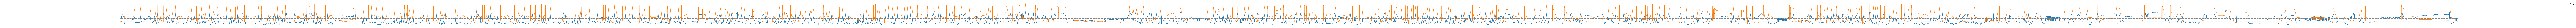

In [107]:
plt.figure(figsize=(500, 5))
plt.plot(events["spout_dist_to_snout"], label='Snout')
plt.plot(events["spout_dist_to_tail"], label='Tail')
plt.hlines(120, 0, len(events), colors='gray', linestyles='dashed', label='Threshold')
plt.hlines(240, 0, len(events), colors='gray', linestyles='dashed', label='Threshold')
plt.legend()

In [111]:
events

,Stim,Timestamp,Corner1,Corner2,Corner3,Corner4,Index,CW,closest_spout,spout_dist_to_snout,spout_dist_to_tail,reward_delivered,reward_count,corner_visit_count,cw_streak,ccw_streak
0,True,697426371923864,False,False,True,False,298,False,2,247.214325,126.505286,False,0,0,0,1
1,True,697426383038136,False,False,True,False,299,False,2,245.412827,127.543181,False,0,0,0,1
2,True,697426394153536,False,False,True,False,300,False,2,245.939651,127.276474,False,0,0,0,1
3,True,697426405267840,False,False,True,False,301,False,2,248.176956,127.379019,False,0,0,0,1
4,True,697426416382648,False,False,True,False,302,False,2,248.917740,127.440150,False,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167240,False,699285191843136,False,True,False,False,167538,True,1,65.701599,236.093500,False,5,6,37,0
167241,False,699285202958216,False,True,False,False,167539,True,1,66.233383,236.832643,False,5,6,37,0
167242,False,699285214072944,False,True,False,False,167540,True,1,68.116173,237.159124,False,5,6,37,0
167243,False,699285225187056,False,True,False,False,167541,True,1,69.458618,237.045995,False,5,6,37,0


In [112]:
print("Number of total rewards delivered:", sum(events["reward_delivered"]))
print("reward_count max:", events["reward_count"].max())
print("corner_visit_count max:", events["corner_visit_count"].max())
print("cw_streak max:", events["cw_streak"].max())
print("ccw_streak max:", events["ccw_streak"].max())

Number of total rewards delivered: 183
reward_count max: 18
corner_visit_count max: 20
cw_streak max: 37
ccw_streak max: 65


In [120]:
# Find the .avi video file in the DLC folder for this session
avi_files = glob(f"{dlc_dir}/*{date_str.replace('-', '')}*.avi") + glob(f"{dlc_dir}/*{date_str}*.avi")
if not avi_files:
    raise FileNotFoundError(f"No .avi video found in the DLC folder for date {date_str}.")
avi_file = avi_files[0]
print("Using video:", avi_file)

# Set up output directory for clips
clip_dir = os.path.join(dlc_dir, "reward_clips")
os.makedirs(clip_dir, exist_ok=True)

# Get reward frame indices
reward_indices = events.index[events['reward_delivered']].to_numpy()
fps = 90  # Change if your video has a different frame rate
half_window = int(fps * 1.0)  # 0.5s before and after

# Open video
cap = cv2.VideoCapture(avi_file)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

clip_paths = []
for i, reward_idx in enumerate(reward_indices):
    start_frame = max(0, reward_idx - half_window)
    end_frame = min(total_frames, reward_idx + half_window)
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    out_path = os.path.join(clip_dir, f"reward_clip_{i+1:04d}.avi")
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))
    for f in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        out.write(frame)
    out.release()
    clip_paths.append(out_path)
    print(f"Saved: {out_path}")

cap.release()
print("All reward clips saved to:", clip_dir)

# --- Now sample 49 random clips and tile as GIF ---
if len(clip_paths) < 49:
    raise ValueError("Not enough reward clips to sample 49.")

sampled_clips = random.sample(clip_paths, 49)

gifs = []
for i, clip in enumerate(sampled_clips):
    cap = cv2.VideoCapture(clip)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(Image.fromarray(frame_rgb))
    cap.release()
    gifs.append(frames)
    print(f"Loaded {len(frames)} frames from {clip}")

min_frames = min(len(g) for g in gifs)
gifs = [g[:min_frames] for g in gifs]

frame_width, frame_height = gifs[0][0].size
gifs = [[f.resize((frame_width, frame_height), Image.LANCZOS) for f in gif] for gif in gifs]

tiled_frames = []
for frame_idx in range(min_frames):
    grid = Image.new('RGB', (frame_width*7, frame_height*7))
    for i in range(49):
        row, col = divmod(i, 7)
        frame = gifs[i][frame_idx]
        grid.paste(frame, (col*frame_width, row*frame_height))
    tiled_frames.append(grid)

tiled_gif_path = os.path.join(clip_dir, "tiled_reward_clips.gif")
tiled_frames[0].save(
    tiled_gif_path,
    save_all=True,
    append_images=tiled_frames[1:],
    duration=1000//fps,  # ms per frame
    loop=0
)
print(f"Tiled GIF saved to {tiled_gif_path}")

Using video: D:\Neuropixels\DLC\9153\9153_Day5_4rewards2025-01-29.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0001.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0001.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0002.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0002.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0003.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0003.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0004.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0004.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0005.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0005.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0006.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0006.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0007.avi
Saved: D:\Neuropixels\DLC\9153\reward_clips\reward_clip_0007.avi
Saved: D:\Neuropixel

KeyboardInterrupt: 